# Add in toolpath sections

Here will be a quick development notebook describing how we key in toolpath sections, which we'll add to the tools module

Also we'll have a couple of plots etc

In [1]:
import sys
import os
import importlib # Used during testing if I need to reload modules
import time

import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.stats

In [2]:
try:
    import ngif_romar.tools
except ModuleNotFoundError as error:
    # If not in path/installed, use relative import
    module_path = os.path.abspath(os.path.join(".."))
    sys.path.append(module_path)
    import ngif_romar.tools as tools

In [3]:
dataset_path = os.path.join("..", "data", "SN2", "20200930_1500_")
logfile_path = os.path.join(dataset_path, "Data.dat")
meta_dict, data_df = tools.read_data(logfile_path)

In [4]:
data_df.head()

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,revolutionSpeed_1,powderGasFlow_1,stirrerValue_2,revolutionSpeed_2,powderGasFlow_2,flowWatch,meltpoolThreshold,protectionGlasTemperature
0,31201,0.0,0.0,0.0,0.0,0.0,8700,1752.0,2000,500,400,600,0,0,0,2872,506,19.2
1,31301,0.0,0.0,0.0,0.0,0.0,10465,1747.0,2000,500,400,600,0,0,0,2872,506,19.2
2,31401,0.0,0.0,0.0,0.0,0.0,10132,1760.0,2000,500,400,600,0,0,0,2872,506,19.2
3,31501,0.0,0.0,0.0,0.0,0.0,9926,1764.0,2000,500,400,600,0,0,0,2864,506,19.2
4,31601,0.0,0.0,0.0,0.0,0.0,10454,1767.0,2000,500,400,600,0,0,0,2864,506,19.2


In [5]:
data_df = tools.post_process_log_data(data_df)
data_df.head()

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,v_x(mm/ms),v_y(mm/ms),v_z(mm/ms),|v|(mm/ms),phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),toolpath_key
0,31201,0.0,0.0,0.0,0.0,0.0,8700,1752.0,2000,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-1.0
1,31301,0.0,0.0,0.0,0.0,0.0,10465,1747.0,2000,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100,0,0.0
2,31401,0.0,0.0,0.0,0.0,0.0,10132,1760.0,2000,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,200,0,0.0
3,31501,0.0,0.0,0.0,0.0,0.0,9926,1764.0,2000,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300,0,0.0
4,31601,0.0,0.0,0.0,0.0,0.0,10454,1767.0,2000,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400,0,0.0


In [6]:
frames_path = os.path.join(dataset_path, "Frames")
data_df = tools.link_camera_frames_to_df(data_df, frame_folder_path=frames_path)
data_df.head()

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,v_y(mm/ms),v_z(mm/ms),|v|(mm/ms),phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),toolpath_key,matching_frame_filename
0,31201,0.0,0.0,0.0,0.0,0.0,8700,1752.0,2000,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-1.0,20200930_150110__31127.dat
1,31301,0.0,0.0,0.0,0.0,0.0,10465,1747.0,2000,500,...,0.0,0.0,0.0,0.0,0.0,0.0,100,0,0.0,20200930_150110__31127.dat
2,31401,0.0,0.0,0.0,0.0,0.0,10132,1760.0,2000,500,...,0.0,0.0,0.0,0.0,0.0,0.0,200,0,0.0,20200930_150110__31127.dat
3,31501,0.0,0.0,0.0,0.0,0.0,9926,1764.0,2000,500,...,0.0,0.0,0.0,0.0,0.0,0.0,300,0,0.0,20200930_150110__31127.dat
4,31601,0.0,0.0,0.0,0.0,0.0,10454,1767.0,2000,500,...,0.0,0.0,0.0,0.0,0.0,0.0,400,0,0.0,20200930_150110__31127.dat


We would like to separate toolpath sections by when the laser is on or off


In [7]:
time_start = time.time()

# Not using None as it upsets numpy arrays, and not using nan as it reqs float arrays, 
# and don't want to use pandas hacks at this stage
data_df["toolpath_key_1"] = -1

# This isn't very pandas like, but a brute force method good enough for testing
# Basically, we iterate through each row, and if laser on time is > 0 we keep the current toolpath key
# If the laser is switched off, increment the toolpath key
toolpath_counter = 0
for i in range(0, len(data_df)):
    if data_df.iloc[i]["laser_on_time(ms)"] > 0:
        data_df.iloc[i, data_df.columns.get_loc("toolpath_key_1")] = toolpath_counter
    if i > 0 and data_df.iloc[i-1]["laser_on_time(ms)"] > 0 and data_df.iloc[i]["laser_on_time(ms)"] == 0:
        toolpath_counter = toolpath_counter + 1
time_end = time.time()
print("Time to do this method: {}s".format(time_end - time_start))

Time to do this method: 93.90725469589233s


In [8]:
time_start = time.time()
# Another way: flag by decreasing laser on time
# https://stackoverflow.com/questions/55059522/how-to-compare-values-with-previous-values-in-groupby-in-pandas
# Selects the rows where the laser has JUST turned off, which is by current coincidence when laser_off_time = 100
data_df[
    np.diff(data_df["laser_on_time(ms)"], prepend=0) < 0
]

data_df["start_new_path"] = 0
data_df.loc[
    np.diff(data_df["laser_on_time(ms)"], prepend=0) < 0
, "start_new_path"] = 1

# Now we have a new col that indicates the start of a new toolpath, need to create another col to increment based on this
data_df["toolpath_key_2"] = data_df["start_new_path"].cumsum()
# Finally, replace all sections where the laser is off with -1, our empty key
data_df.iloc[data_df["laser_on_time(ms)"] == 0, data_df.columns.get_loc("toolpath_key_2")] = -1
time_end = time.time()

print("Time to do this method: {}s".format(time_end - time_start))

Time to do this method: 0.028987646102905273s


In [9]:
# Compare results of two methods
data_df[
    (data_df["toolpath_key_1"] - data_df["toolpath_key_2"]) != 0
]


,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),toolpath_key,matching_frame_filename,toolpath_key_1,start_new_path,toolpath_key_2


And so, the methods are identical in result but orders of magnitude different in runtime

Create a function to add this in

In [10]:
def add_toolpath_key(data_df):
    """
    Adds a key identifying different toolpaths to pandas df
    
    Assumes "laser_on_time(ms)" column has already been added
    
    Args:
        - data_df : Pandas dataframe as produced by tools.read_data, with a laser_on_time(ms) column
    
    Returns:
        data_df
    """
    start_new_path = np.zeros(len(data_df))
    # Create a flag array of zero or one used to flag when laser switches off
    start_new_path[np.diff(data_df["laser_on_time(ms)"], prepend=0) < 0] = 1
    # This flag array can be used to designate different regions by cumsum 
    toolpath_key = np.cumsum(start_new_path)
    # Set the parts of the toolpath_key array where the laser is off to -1
    toolpath_key[data_df["laser_on_time(ms)"] == 0] = -1
    data_df["toolpath_key"] = toolpath_key
    return data_df
data_df = add_toolpath_key(data_df)
    

In [11]:
# Check it's the same
data_df[
    (data_df["toolpath_key"] - data_df["toolpath_key_2"]) != 0
]
# And it is

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),toolpath_key,matching_frame_filename,toolpath_key_1,start_new_path,toolpath_key_2


## Now what can we do with this new toolpath information?

For now I'll throw together some quick plots

In [12]:
importlib.reload(tools)

<module 'ngif_romar.tools' from 'C:\\Users\\Scott Williams\\Documents\\programming\\ngif_romar\\ngif_romar\\tools.py'>

In [13]:
dataset_path = os.path.join("..", "data", "SN2", "20200930_1500_")
logfile_path = os.path.join(dataset_path, "Data.dat")
meta_dict, data_df = tools.read_data(logfile_path)

data_df = tools.post_process_log_data(data_df)

frames_path = os.path.join(dataset_path, "Frames")
data_df = tools.link_camera_frames_to_df(data_df, frame_folder_path=frames_path)
data_df.head()

,t,x,y,z,a,c,meltpoolSize,meltpoolTemp,LaserPower,stirrerValue_1,...,v_y(mm/ms),v_z(mm/ms),|v|(mm/ms),phi(rad),r(mm),phi_dot(rad/ms),laser_on_time(ms),laser_off_time(ms),toolpath_key,matching_frame_filename
0,31201,0.0,0.0,0.0,0.0,0.0,8700,1752.0,2000,500,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,-1.0,20200930_150110__31127.dat
1,31301,0.0,0.0,0.0,0.0,0.0,10465,1747.0,2000,500,...,0.0,0.0,0.0,0.0,0.0,0.0,100,0,0.0,20200930_150110__31127.dat
2,31401,0.0,0.0,0.0,0.0,0.0,10132,1760.0,2000,500,...,0.0,0.0,0.0,0.0,0.0,0.0,200,0,0.0,20200930_150110__31127.dat
3,31501,0.0,0.0,0.0,0.0,0.0,9926,1764.0,2000,500,...,0.0,0.0,0.0,0.0,0.0,0.0,300,0,0.0,20200930_150110__31127.dat
4,31601,0.0,0.0,0.0,0.0,0.0,10454,1767.0,2000,500,...,0.0,0.0,0.0,0.0,0.0,0.0,400,0,0.0,20200930_150110__31127.dat


In [14]:
# A quick way to see how many entries are present, and length etc
data_df["toolpath_key"].value_counts()

-1.0     8685
 3.0      962
 2.0      962
 1.0      962
 4.0      958
         ... 
 80.0     455
 81.0     448
 82.0     438
 83.0     433
 0.0      339
Name: toolpath_key, Length: 87, dtype: int64

In [15]:
print("Length of data_df {}, elements not a part of a toolpath: {}".format(
    len(data_df), len(data_df[data_df["toolpath_key"] == -1])
))

Length of data_df 68304, elements not a part of a toolpath: 8685


Len of subet with toolpath idx 10: 912


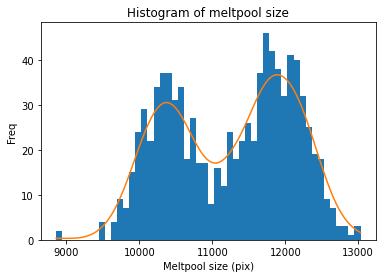

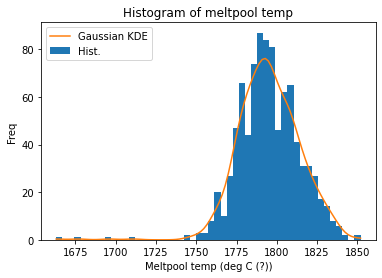

In [16]:
# Look at a single toolpath
toolpath_idx = 10
subset = data_df[
    (data_df["toolpath_key"] == toolpath_idx)
    & (data_df["laser_on_time(ms)"] > 200)
]
print("Len of subet with toolpath idx {}: {}".format(toolpath_idx, len(subset)))

fig, ax = plt.subplots()
hist_result = ax.hist(subset["meltpoolSize"], bins=50)

# Putting in a KDE for demonstration, as bin choice here is annoying
kde = scipy.stats.gaussian_kde(subset["meltpoolSize"])
xs = np.linspace(subset["meltpoolSize"].min(), subset["meltpoolSize"].max(), 100)
ys = kde(xs)
# Rescale, looked up scale factor from stack overflow
# https://stackoverflow.com/a/16090002
bin_width = hist_result[1][1] - hist_result[1][0]
scale = bin_width * len(subset["meltpoolSize"])
ax.plot(xs, ys * scale, label="Gaussian KDE")

ax.set_xlabel("Meltpool size (pix)")
ax.set_ylabel("Freq")
ax.set_title("Histogram of meltpool size")
plt.show()

fig, ax = plt.subplots()
hist_result = ax.hist(subset["meltpoolTemp"], bins=50, label="Hist.")

# Putting in a KDE for demonstration, as bin choice here is annoying
kde = scipy.stats.gaussian_kde(subset["meltpoolTemp"])
xs = np.linspace(subset["meltpoolTemp"].min(), subset["meltpoolTemp"].max(), 100)
ys = kde(xs)
# Rescale, looked up scale factor from stack overflow
# https://stackoverflow.com/a/16090002
bin_width = hist_result[1][1] - hist_result[1][0]
scale = bin_width * len(subset["meltpoolTemp"])
ax.plot(xs, ys * scale, label="Gaussian KDE")

ax.legend()
ax.set_xlabel("Meltpool temp (deg C (?))")
ax.set_ylabel("Freq")
ax.set_title("Histogram of meltpool temp")
plt.show()

Len of subet with toolpath idx 50: 685


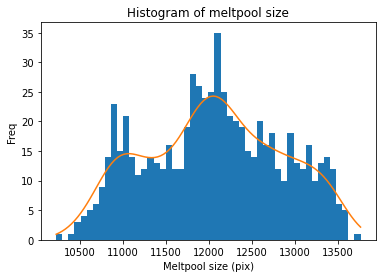

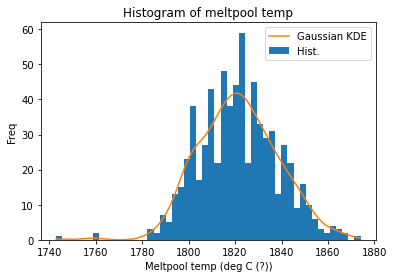

In [17]:
# Look at a single toolpath
toolpath_idx = 50
subset = data_df[
    (data_df["toolpath_key"] == toolpath_idx)
    & (data_df["laser_on_time(ms)"] > 200)
]
print("Len of subet with toolpath idx {}: {}".format(toolpath_idx, len(subset)))

fig, ax = plt.subplots()
hist_result = ax.hist(subset["meltpoolSize"], bins=50)

# Putting in a KDE for demonstration, as bin choice here is annoying
kde = scipy.stats.gaussian_kde(subset["meltpoolSize"])
xs = np.linspace(subset["meltpoolSize"].min(), subset["meltpoolSize"].max(), 100)
ys = kde(xs)
# Rescale, looked up scale factor from stack overflow
# https://stackoverflow.com/a/16090002
bin_width = hist_result[1][1] - hist_result[1][0]
scale = bin_width * len(subset["meltpoolSize"])
ax.plot(xs, ys * scale, label="Gaussian KDE")

ax.set_xlabel("Meltpool size (pix)")
ax.set_ylabel("Freq")
ax.set_title("Histogram of meltpool size")
plt.show()

fig, ax = plt.subplots()
hist_result = ax.hist(subset["meltpoolTemp"], bins=50, label="Hist.")

# Putting in a KDE for demonstration, as bin choice here is annoying
kde = scipy.stats.gaussian_kde(subset["meltpoolTemp"])
xs = np.linspace(subset["meltpoolTemp"].min(), subset["meltpoolTemp"].max(), 100)
ys = kde(xs)
# Rescale, looked up scale factor from stack overflow
# https://stackoverflow.com/a/16090002
bin_width = hist_result[1][1] - hist_result[1][0]
scale = bin_width * len(subset["meltpoolTemp"])
ax.plot(xs, ys * scale, label="Gaussian KDE")

ax.legend()
ax.set_xlabel("Meltpool temp (deg C (?))")
ax.set_ylabel("Freq")
ax.set_title("Histogram of meltpool temp")
plt.show()

Note that eg. idx 10, idx 75 have multiple peaks in pool size hist/KDE

Can also groupby the key and look at variations in mean between toolpaths

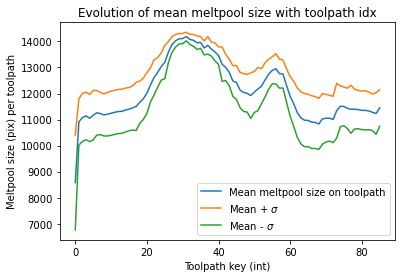

In [18]:
means = data_df[data_df["toolpath_key"] > -1].groupby("toolpath_key").mean()["meltpoolSize"]
stds = data_df[data_df["toolpath_key"] > -1].groupby("toolpath_key").std()["meltpoolSize"]

fig, ax = plt.subplots()
ax.plot(means, label="Mean meltpool size on toolpath")
ax.plot(means+stds, label="Mean + $\\sigma$")
ax.plot(means-stds, label="Mean - $\\sigma$")
ax.set_xlabel("Toolpath key (int)")
ax.set_ylabel("Meltpool size (pix) per toolpath")
ax.set_title("Evolution of mean meltpool size with toolpath idx")
ax.legend()
plt.show()

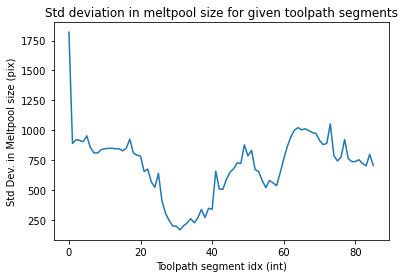

In [19]:
fig, ax = plt.subplots()
ax.plot(stds)
ax.set_title("Std deviation in meltpool size for given toolpath segments")
ax.set_xlabel("Toolpath segment idx (int)")
ax.set_ylabel("Std Dev. in Meltpool size (pix)")
plt.show()